In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import torch.quantization as quantization
from torch.ao.quantization import QuantStub, DeQuantStub
import copy
from tabulate import tabulate


In [7]:
# Comprobamos si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device='cpu'
# Transformaciones para el dataset CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambiamos el tamaño de las imágenes para que se ajusten a ResNet-50
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizamos las imágenes
])

# Cargamos el dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


100%|█████████████████████████████████████████████████████████████| 170M/170M [00:07<00:00, 22.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# Definimos el modelo ResNet-50 preentrenado
model = resnet50(weights=True)

# Congelamos todas las capas menos la fc original
for param in model.parameters():
    param.requires_grad = False

# Añadimos una capa adicional
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),  # Nueva capa oculta
    nn.ReLU(),                             # Activación
    nn.Dropout(0.5),                       # Dropout para regularización
    nn.Linear(256, 10)                     # Capa final con 10 clases
)

# Solo entrenamos las capas añadidas
for param in model.fc.parameters():
    param.requires_grad = True

# Añadir stubs de cuantización
class QuantizedResNet50(nn.Module):
    def __init__(self, model):
        super(QuantizedResNet50, self).__init__()
        self.quant = QuantStub()
        self.model = model
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)  # Cuantizar entrada
        x = self.model(x)  # Modelo original
        x = self.dequant(x)  # Descuantizar salida
        return x

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import torch
import time
import numpy as np
from torchsummary import summary


qat5bits_model=copy.deepcopy(model)
qat8bits_model=copy.deepcopy(model)
ptq5bits_model=copy.deepcopy(model)
ptq8bits_model=copy.deepcopy(model)

original_model=torch.load('ResnetModels/modelo_completo_resnet50_cifar10.pth')
original_model.to(device)
original_model.eval()

qat8bits_model = torch.jit.load('ResnetModels/modelo_qat_resnet50_cifar10_jit.pth')
qat8bits_model.to(device)
qat8bits_model.eval()

qat5bits_model = torch.jit.load('ResnetModels/modelo_qat5bits_resnet50_cifar10_jit.pth')
qat5bits_model.to(device)
qat5bits_model.eval()  

ptq5bits_model=torch.jit.load('ResnetModels/modelo_ptq5bits_resnet50_cifar10_jit.pth')
ptq5bits_model.to(device)
ptq5bits_model.eval()

ptq8bits_model=torch.jit.load('ResnetModels/modelo_ptq_resnet50_cifar10_jit.pth')
ptq8bits_model.to(device)
ptq8bits_model.eval()





/tmp/ipykernel_27933/853480381.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model=torch.load('ResnetModels/modelo_completo_resnet50_cifar10.pth')


RecursiveScriptModule(
  original_name=GraphModule
  (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Module
    (0): RecursiveScriptModule(
      original_name=Module
      (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
      (conv2): RecursiveScriptModule(original_name=ConvReLU2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (downsample): RecursiveScriptModule(
        original_name=Module
        (0): RecursiveScriptModule(original_name=Conv2d)
      )
    )
    (1): RecursiveScriptModule(
      original_name=Module
      (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
      (conv2): RecursiveScriptModule(original_name=ConvReLU2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
    )
    (2): RecursiveScriptModule(
      original_name=Module
      (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
      (conv

In [11]:
print(dir(qat8bits_model.parameters()))

['__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__name__', '__ne__', '__new__', '__next__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'close', 'gi_code', 'gi_frame', 'gi_running', 'gi_suspended', 'gi_yieldfrom', 'send', 'throw']


In [12]:
print(qat8bits_model.named_parameters)

<bound method Module.named_parameters of RecursiveScriptModule(
  original_name=GraphModule
  (model): RecursiveScriptModule(
    original_name=Module
    (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Module
      (0): RecursiveScriptModule(
        original_name=Module
        (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
        (conv2): RecursiveScriptModule(original_name=ConvReLU2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (downsample): RecursiveScriptModule(
          original_name=Module
          (0): RecursiveScriptModule(original_name=Conv2d)
        )
      )
      (1): RecursiveScriptModule(
        original_name=Module
        (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
        (conv2): RecursiveScriptModule(original_name=ConvReLU2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
 

In [13]:
model.train()
state_dict = model.state_dict()
print(dir(state_dict))
for key, value in state_dict.items():
    print(f"Nombre del parámetro/buffer: {key}, Tamaño: {value.size()}, Requiere gradiente: {value.requires_grad}")
'''for name, param in state_dict.items():
    print(name, param.size())'''


['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '_metadata', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'move_to_end', 'pop', 'popitem', 'setdefault', 'update', 'values']
Nombre del parámetro/buffer: conv1.weight, Tamaño: torch.Size([64, 3, 7, 7]), Requiere gradiente: False
Nombre del parámetro/buffer: bn1.weight, Tamaño: torch.Size([64]), Requiere gradiente: False
Nombre del parámetro/buffer: bn1.bias, Tamaño: torch.Size([64]), Requiere gradiente: False
Nombre del parámetro/buffer: bn1.running_mean, Tamaño: torch.Size([64]), Requiere gradiente: F

'for name, param in state_dict.items():\n    print(name, param.size())'

In [ ]:
input_sample = torch.randn(1, 3, 224, 224)  


# Función para medir el tiempo de ejecución de la predicción
def measure_execution_time(model, input_sample):
    #model.eval()  # Cambiar el modelo a modo evaluación
    with torch.no_grad():
        start_time = time.time()
        model(input_sample)
        end_time = time.time()
    return (end_time - start_time)/1000

def get_model_parameters(model):
    total_params = 0
    trainable_params = 0
    
    for name, module in model.named_modules():
        # Si es una capa cuantizada (como Linear o Conv2d), accedemos a los pesos de forma diferente
        if isinstance(module, torch.nn.quantized.Linear) or isinstance(module, torch.nn.quantized.Conv2d):
            # Obtenemos los pesos de la capa cuantizada
            weight = module.weight()
            total_params += weight.numel()
            # En modelos cuantizados, los pesos no son entrenables en el sentido tradicional
        elif hasattr(module, 'weight') and module.weight is not None:
            # Para capas no cuantizadas, contamos los pesos normalmente
            total_params += module.weight.numel()
            if module.weight.requires_grad:
                trainable_params += module.weight.numel()
        
        # Contamos los parámetros del bias si están presentes
        if hasattr(module, 'bias'):
            # Si bias es una función (caso de capas cuantizadas), accedemos a ella correctamente
            bias = module.bias() if callable(module.bias) else module.bias
            if bias is not None:
                total_params += bias.numel()
                if bias.requires_grad:
                    trainable_params += bias.numel()

    return total_params, trainable_paramsmodel=torch.load('quantization_output/ResNet_int.xmodel')
total_params, trainable_params = get_model_parameters(qat8bits_model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 0
Trainable parameters: 0


In [6]:
model_summaries = []


print('Original Model')
pytorch_total_params = sum(p.numel() for p in original_model.parameters())
print('Number of parameters',pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in original_model.parameters() if p.requires_grad)
print('Number of trainable parameters',pytorch_total_params)
execution_time=measure_execution_time(original_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['Original Model', pytorch_total_params, pytorch_trainable_params, execution_time])


print('QAT 8 bits Model')
total, trainable_params = get_model_parameters(qat8bits_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable_params}")
execution_time=measure_execution_time(qat8bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['QAT 8 bits Model', total, trainable_params, execution_time])


print('QAT 5 bits Model')
total, trainable_params = get_model_parameters(qat5bits_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable_params}")
execution_time=measure_execution_time(qat5bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['QAT 5 bits Model', total, trainable_params, execution_time])


print('PTQ 5 bits Model')
pytorch_total_params = sum(p.numel() for p in ptq5bits_model.parameters())
print('Number of parameters',pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in ptq5bits_model.parameters() if p.requires_grad)
print('Number of trainable parameters',pytorch_total_params)
execution_time=measure_execution_time(ptq5bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['PTQ 5 bits Model', pytorch_total_params, pytorch_trainable_params, execution_time])


print('PTQ 8 bits Model')
total, trainable_params = get_model_parameters(ptq8bits_model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable_params}")
execution_time=measure_execution_time(ptq8bits_model, input_sample)
print('Time execution', execution_time, 'miliseconds')
print('\n')
model_summaries.append(['PTQ 8 bits Model', total, trainable_params, execution_time])



headers = ['Model', 'Total Parameters', 'Trainable Parameters', 'Execution Time (miliseconds)']
print(tabulate(model_summaries, headers, tablefmt='grid'))



Original Model
Number of parameters 24035146
Number of trainable parameters 24035146
Time execution 6.660580635070801e-05 miliseconds


QAT 8 bits Model
Error al procesar el módulo model.conv1: 'torch._C.ScriptObject' object is not callable
Error al procesar el módulo model.layer1.0.conv1: 'torch._C.ScriptObject' object is not callable
Error al procesar el módulo model.layer1.0.conv2: 'torch._C.ScriptObject' object is not callable
Error al procesar el módulo model.layer1.0.conv3: 'torch._C.ScriptObject' object is not callable
Error al procesar el módulo model.layer1.0.downsample.0: 'torch._C.ScriptObject' object is not callable
Error al procesar el módulo model.layer1.1.conv1: 'torch._C.ScriptObject' object is not callable
Error al procesar el módulo model.layer1.1.conv2: 'torch._C.ScriptObject' object is not callable
Error al procesar el módulo model.layer1.1.conv3: 'torch._C.ScriptObject' object is not callable
Error al procesar el módulo model.layer1.2.conv1: 'torch._C.ScriptObject'

In [16]:
print(dir(qat8bits_model))


['T_destination', '__annotations__', '__bool__', '__call__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__jit_unused_properties__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__reduce_package__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_c', '_call_impl', '_compiled_call_impl', '_concrete_type', '_constants_set', '_construct', '_disable_script_meta', '_finalize_scriptmodule', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_initial

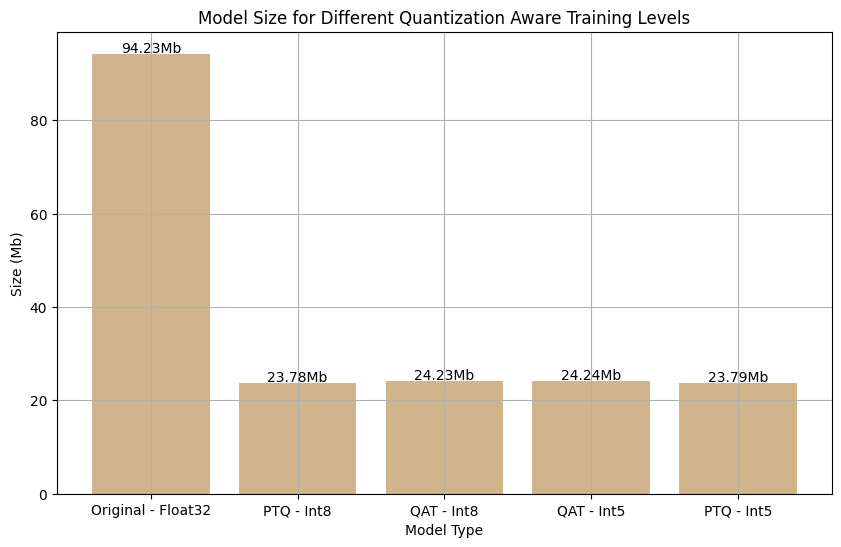

In [11]:
import matplotlib.pyplot as plt
import os

original_model_size = os.path.getsize('ResnetModels/modelo_completo_resnet50_cifar10.pth')/1024/1000
qat5bits_model_size = os.path.getsize('ResnetModels/modelo_qat5bits_resnet50_cifar10_jit.pth') / 1024/1000
qat8bits_model_size = os.path.getsize('ResnetModels/modelo_qat_resnet50_cifar10_jit.pth') / 1024/1000
ptq5bits_model_size = os.path.getsize('ResnetModels/modelo_ptq5bits_resnet50_cifar10_jit.pth')/1024/1000
ptq8bits_model_size = os.path.getsize('ResnetModels/modelo_ptq_resnet50_cifar10_jit.pth') / 1024/1000

# Etiquetas para cada modelo
labels = ['Original - Float32', 'PTQ - Int8', 'QAT - Int8', 'QAT - Int5', 'PTQ - Int5']

# Valores de tamaño
sizes = [original_model_size, ptq8bits_model_size, qat8bits_model_size, qat5bits_model_size, ptq5bits_model_size]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color='tan')

# Agregar títulos y etiquetas
plt.title('Model Size for Different Quantization Aware Training Levels')
plt.xlabel('Model Type')
plt.ylabel('Size (Mb)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(sizes):
    plt.text(i, v + 0.2, f'{v:.2f}Mb', ha='center', fontsize=10)

# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.show()

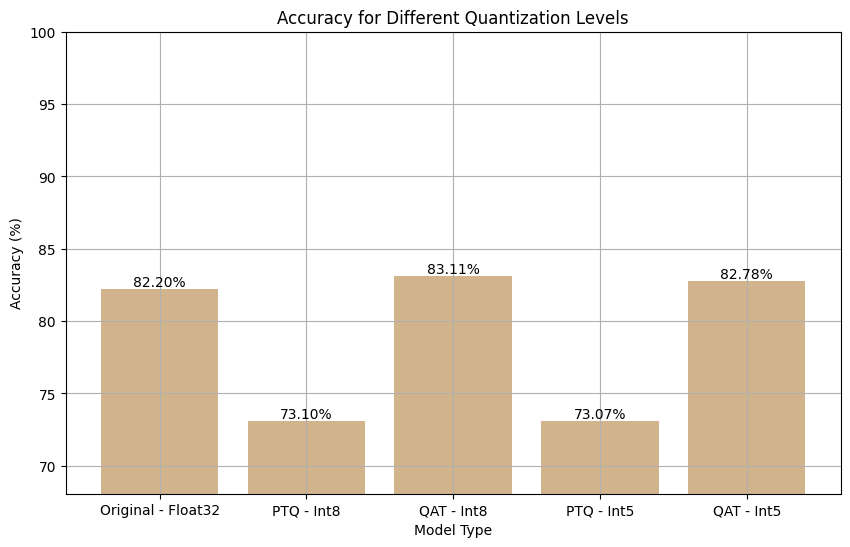

In [9]:
import matplotlib.pyplot as plt

# Etiquetas para cada modelo
labels = ['Original - Float32', 'PTQ - Int8', 'QAT - Int8', 'PTQ - Int5', 'QAT - Int5']

acc_original_model = 82.2
acc_postTraining_8bit = 73.1
acc_qat_8bits = 83.11
acc_postTraining_5bit = 73.07
acc_qat_5bits = 82.78


# Valores de precisión
accuracies = [acc_original_model, acc_postTraining_8bit, acc_qat_8bits, acc_postTraining_5bit, acc_qat_5bits]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color='tan')

# Agregar títulos y etiquetas
plt.title('Accuracy for Different Quantization Levels')
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.2, f'{v:.2f}%', ha='center', fontsize=10)

# Mostrar la gráfica
plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.show()
